In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from prophet import Prophet
import numpy as np
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Rogeriom49/brent_oil_time_series/refs/heads/main/datasets/dados_mes_ano.csv', sep=",")
df.head()

,data,preco,ano,mes
0,2024-09-30,72.35,2024,9
1,2024-09-27,71.63,2024,9
2,2024-09-26,73.06,2024,9
3,2024-09-25,75.40,2024,9
4,2024-09-24,75.29,2024,9


In [4]:
# Informações sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11267 entries, 0 to 11266
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11267 non-null  object 
 1   preco   11267 non-null  float64
 2   ano     11267 non-null  int64  
 3   mes     11267 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 352.2+ KB


In [5]:
# Converte a coluna 'data' para o formato de data
df['data'] = pd.to_datetime(df['data'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11267 entries, 0 to 11266
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11267 non-null  datetime64[ns]
 1   preco   11267 non-null  float64       
 2   ano     11267 non-null  int64         
 3   mes     11267 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 352.2 KB


In [7]:
# verificamos as estatisticas descritivas
df.describe()

,data,preco,ano,mes
count,11267,11267.000000,11267.000000,11267.000000
mean,2006-10-03 05:56:34.869974272,53.262665,2006.254904,6.528268
min,1987-05-20 00:00:00,9.100000,1987.000000,1.000000
25%,1998-06-23 12:00:00,20.580000,1998.000000,4.000000
50%,2007-05-15 00:00:00,48.810000,2007.000000,7.000000
75%,2015-03-04 12:00:00,76.785000,2015.000000,9.000000
max,2024-09-30 00:00:00,143.950000,2024.000000,12.000000
std,NaN,33.184672,10.219784,3.421740


In [8]:
# Verificando a data do menor preço histórico
display(df['data'].loc[df['preco'] == df['preco'].min()])


8329   1998-12-10
Name: data, dtype: datetime64[ns]

In [9]:
# verificamos a data com maior valor histórico
df['data'].loc[df['preco'] == df['preco'].max()].dt.strftime('%d/%m/%Y')

5221    07/07/2008
5225    03/07/2008
Name: data, dtype: object

In [10]:
df['quadrimestre'] = df['data'].dt.quarter

In [11]:
df.head()

,data,preco,ano,mes,quadrimestre
0,2024-09-30,72.35,2024,9,3
1,2024-09-27,71.63,2024,9,3
2,2024-09-26,73.06,2024,9,3
3,2024-09-25,75.40,2024,9,3
4,2024-09-24,75.29,2024,9,3


In [12]:
b1 = [1,2,3,4,5,6]
b2 = [7,8,9,10,11,12]

def bimestre(x):
    if x in b1:
        return 1
    elif x in b2:
        return 2

In [13]:
t1 = [1,2,3,4]
t2 = [5,6,7,8]
t3 = [9,10,11,12]

def trimestre(x):
    if x in t1:
        return 1    
    elif x in t2:
        return 2
    elif x in t3:
        return 3

In [14]:
# Aplica a função de criação da coluna bimestre ao DataFrame
df['bimestre'] = df['mes'].apply(bimestre)

In [15]:
# Aplica a função de criação da coluna trimestre ao DataFrame
df['trimestre'] = df['mes'].apply(trimestre)

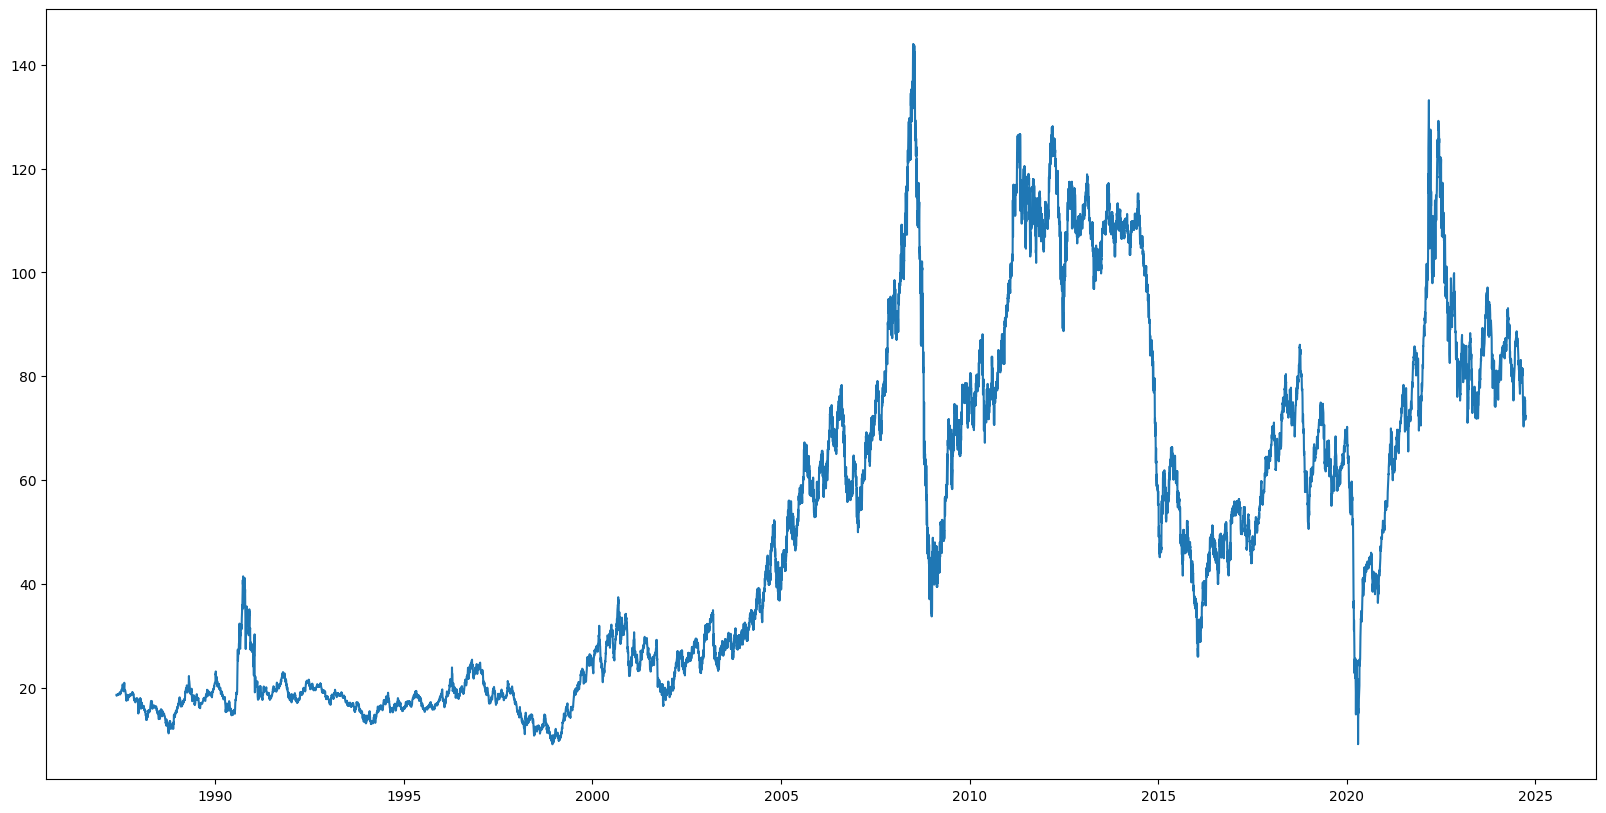

In [16]:
#  Visualização dos dados
# Plotamos o gráfico para encontrar anomalias, picos e tendencias
# Nesse caso vemos aumentos e quedas do valor brusca em 2008, 2014. 2-15, 2020 e 2022

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['data'], df['preco'])
plt.show()

In [17]:
x = df[['data', 'preco']].set_index('data')

In [18]:
x.head()

,preco
data,
2024-09-30,72.35
2024-09-27,71.63
2024-09-26,73.06
2024-09-25,75.40
2024-09-24,75.29


In [19]:
resultados = seasonal_decompose(x, period=365)

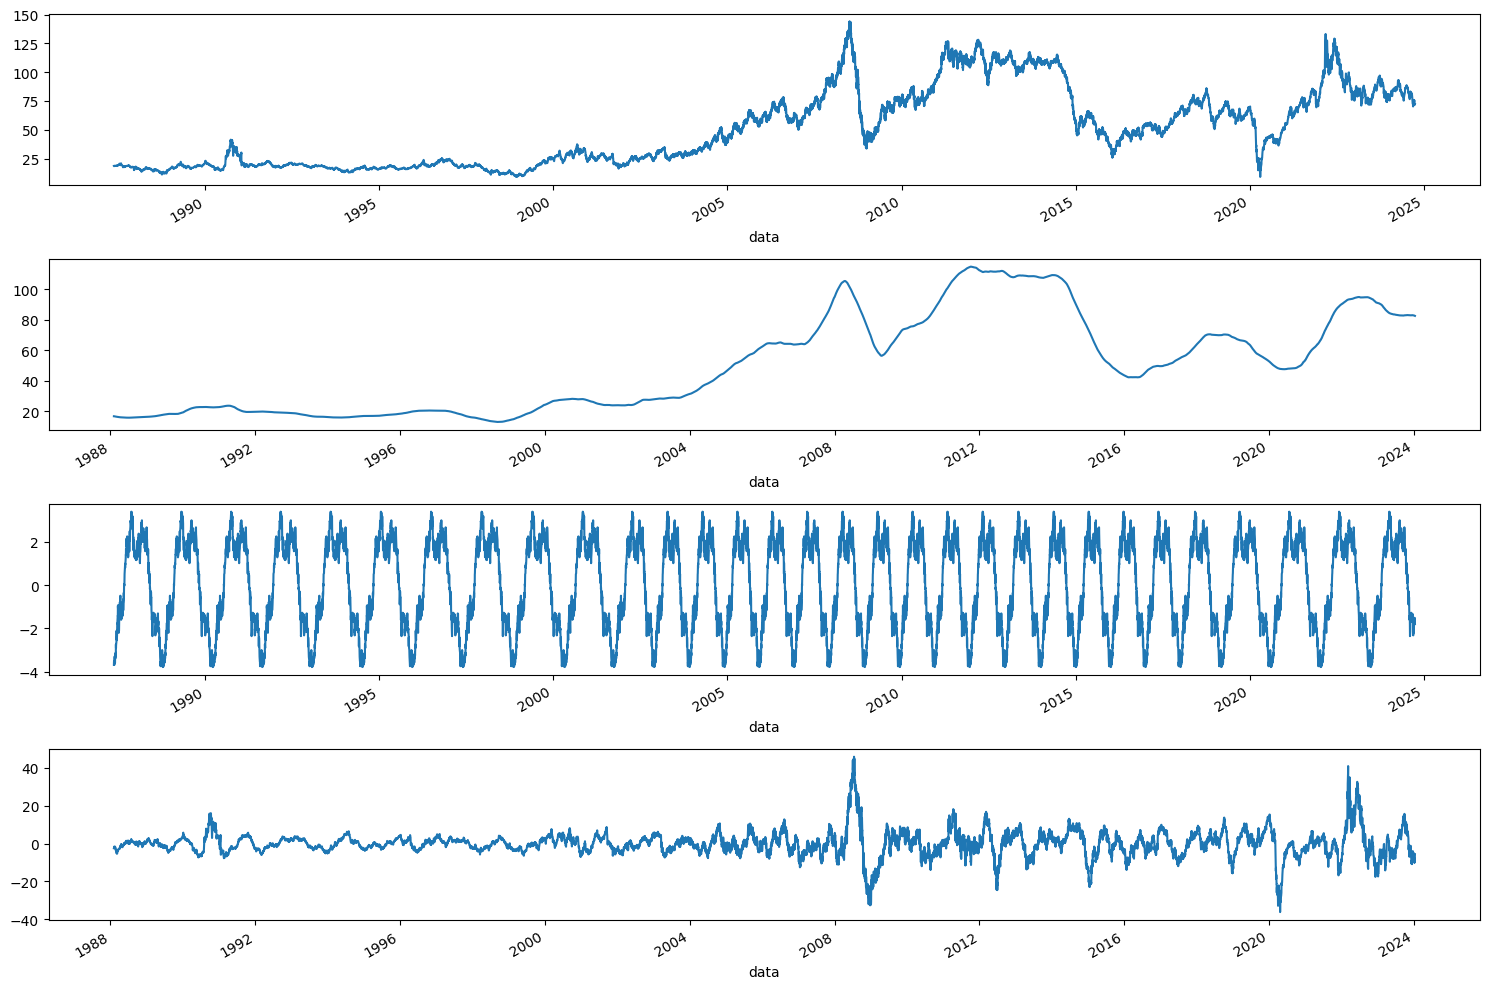

In [20]:
# Analise de tendencia, sazonalidade e ruído
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)
plt.tight_layout()

In [21]:
# criação do dataframe para criação do mocelo
df_modelo = df[['data', 'preco']].rename(columns={'data': 'ds', 'preco': 'y'})
df_modelo.head()

,ds,y
0,2024-09-30,72.35
1,2024-09-27,71.63
2,2024-09-26,73.06
3,2024-09-25,75.40
4,2024-09-24,75.29


In [22]:
# Criação da função para previsão
def previsao(df, model):
    model.fit(df)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    return forecast

In [23]:
def validacao(model):
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '30 days')
    df_m = performance_metrics(df_cv)
    return df_m

In [24]:
model = Prophet()
previsao = previsao(df_modelo, model)

08:44:03 - cmdstanpy - INFO - Chain [1] start processing
08:44:15 - cmdstanpy - INFO - Chain [1] done processing


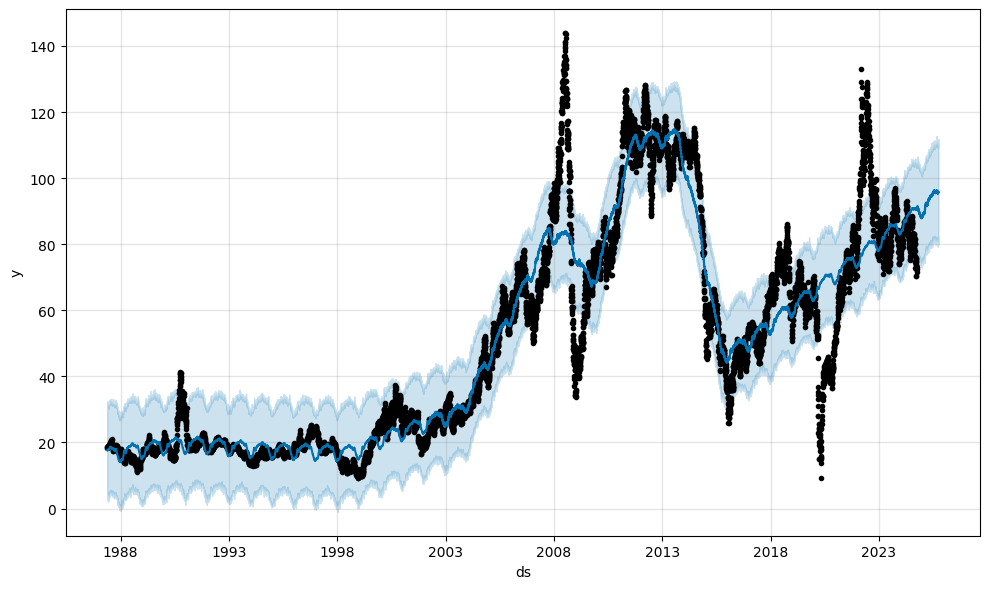

In [25]:
fig1 = model.plot(previsao)

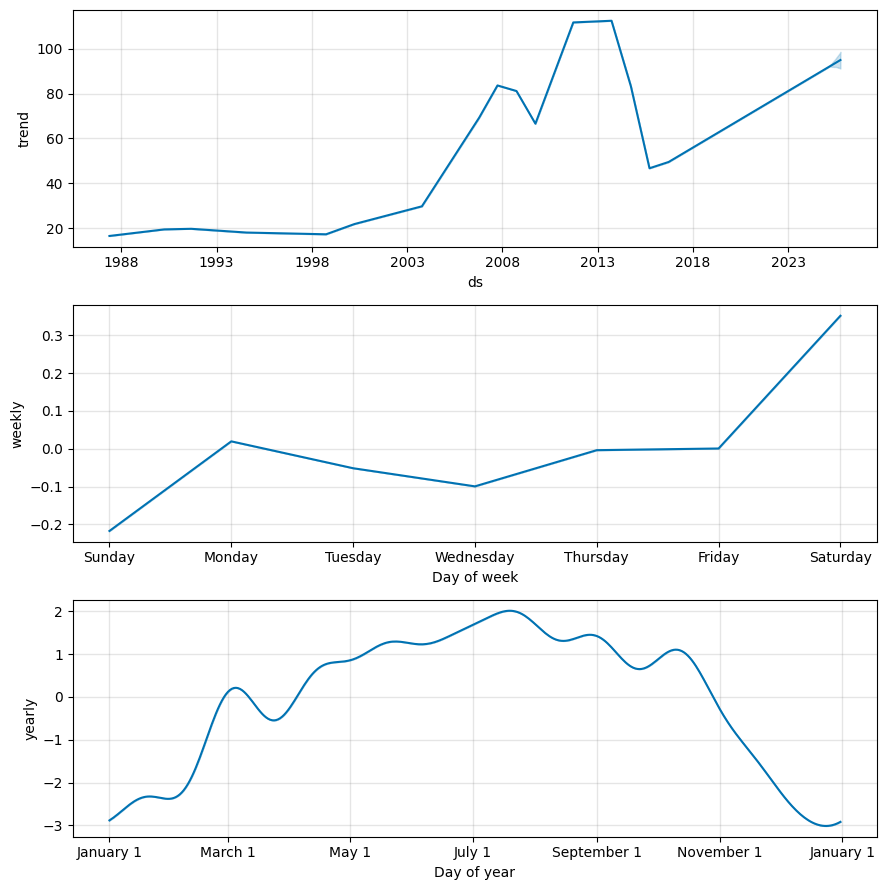

In [26]:
fig2 = model.plot_components(previsao)

In [27]:
# Validação do modelo
df_metrics = validacao(model)
df_metrics

  0%|          | 0/72 [00:00<?, ?it/s]08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 1/72 [00:00<00:17,  4.17it/s]08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 2/72 [00:00<00:22,  3.17it/s]08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 3/72 [00:00<00:23,  2.96it/s]08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 4/72 [00:01<00:22,  3.08it/s]08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 5/72 [00:01<00:22,  3.00it/s]08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 6/72 [00:02<00:29,  2.20it/s]08:44:21

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,310.277871,17.614706,12.008967,0.219440,0.159126,0.213276,0.461732
1,4 days,285.769260,16.904711,11.531679,0.204125,0.153990,0.202798,0.472754
2,5 days,278.228541,16.680184,11.467793,0.205434,0.144284,0.203119,0.475135
3,6 days,292.820023,17.111985,11.751269,0.217738,0.144284,0.210308,0.458101
4,7 days,323.379656,17.982760,12.282353,0.235489,0.144202,0.220718,0.444041
5,8 days,341.527036,18.480450,12.550383,0.240976,0.151534,0.226822,0.432775
6,9 days,338.069204,18.386658,12.518353,0.236546,0.154888,0.228128,0.442004
7,10 days,329.843013,18.161581,12.337568,0.227636,0.163308,0.222788,0.448417
8,11 days,310.670199,17.625839,12.059245,0.218088,0.159443,0.214987,0.462245
9,12 days,291.053453,17.060289,11.762078,0.215224,0.163231,0.210465,0.466709
